In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import pickle
import torch
import astropy.units as u

from typing import Tuple, Optional, Union
from itertools import cycle
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from sklearn.model_selection import train_test_split
from neural_net import normalize_arr, get_model, CustomLoss, resume
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, accuracy_score
from sklearn.impute import KNNImputer
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler

from preprocessing.preprocessing import ab_mag_to_flux
from SPLASH.pipeline import Splash_Pipeline

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [2]:
# Grab some helpful data
from sed_nn import load_and_preprocess
all_photo, _, _, _, _, _, _, _, _, photo_mean, photo_std, photo_err_norm = load_and_preprocess()
from host_prop_nn import load_and_preprocess
all_cat, _, _, _, _, _, _, _, _, _, _, hp_photo_mean, hp_photo_std, _, _, hp_cat_mean, hp_cat_std, _ = load_and_preprocess()

2024-09-17 14:32:01,299 - sed_nn.py - INFO - Importing photometry data
2024-09-17 14:32:04,288 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-09-17 14:32:04,300 - sed_nn.py - INFO - Importing photometry data
2024-09-17 14:32:06,852 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-09-17 14:32:06,861 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-09-17 14:32:06,863 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-09-17 14:32:08,756 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
2024-09-17 14:32:08,935 - host_prop_nn.py - INFO - Importing photometry data
2024-09-17 14:32:10,220 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-09-17 14:32:10,250 - host_prop_nn.py - INFO - Dropping 2594528 / 2691042 photozs!
2024-09-17 14:32:10,323 - host_prop_nn.py - INFO - Importing photometry data
2024-09-17 14:32:10,379 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.08274563 -1.85131022 -1.91613353 -1.66802481 -1.64246513]
 	std = [0.62591803 0.58210564 0.62691966 0.58754192 0.59550117]
2024-09-17 14:32:10,381 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 9.99878348 -0.13575662 -0.3170729 ]
 	std = [0.83429481 1.04090293 0.26033958]
2024-09-17 14:32:10,382 - host_prop_nn.py - INFO - Length = 84672


HEEERRRREE [[ 0.68735514 -3.73327686 -2.95426938]
 [-1.68488085 -0.31710368 -3.29128709]
 [ 1.28118105 -1.88014654 -1.59697336]
 ...
 [-0.91752005 -0.17525813 -0.08646464]
 [-3.6916955  -2.32110538 -3.94510607]
 [-0.55604096 -1.49926118 -0.48175502]]
[ 9.99878348 -0.13575662 -0.3170729 ]


In [3]:
def normalize_arr(arr: np.ndarray, errors: np.ndarray = None, axis: int = 0, mean: float = None, std: float = None) -> (float, float, float, Optional[np.ndarray]):
    """Normalize numpy array along given axis and its errors if given."""
    if mean is None:
        mean = np.mean(arr, axis=axis, keepdims=True)
    if std is None:
        std = np.std(arr, axis=axis, keepdims=True)
    if not errors is None:
        return (arr - mean) / std, mean[0], std[0], errors / std
    else:
        return (arr - mean) / std, mean, std

In [4]:
# Function to calculate angular separation
def get_angular_separation(ra1, dec1, ra2, dec2, unit1='deg', unit2='arcsec'):
    coord1 = SkyCoord(ra1, dec1, unit=unit1)
    coord2 = SkyCoord(ra2, dec2, unit=unit2)
    return coord1.separation(coord2).arcsec

# Zou

## Infer properties

In [5]:
# Get the preprocessed pstar data
zou_df = pd.read_csv("/Users/adamboesky/Research/ay98/clean_data/classified_zou_hosts_pcc.csv")
zou_df = zou_df.iloc[:, 1:]
print(zou_df.columns, len(zou_df))
zou_df.head()

Index(['gal_id', 'host_ra', 'host_dec', 'SN_ra', 'SN_dec', 'SN_class', 'G',
       'G_err', 'R', 'R_err', 'I', 'I_err', 'Z', 'Z_err', 'Y', 'Y_err', 'J',
       'J_err', 'H', 'H_err', 'Ks', 'Ks_err', 'CH1', 'CH1_err', 'CH2',
       'CH2_err', 'MIPS24', 'MIPS24_err', 'MIPS70', 'MIPS70_err', 'PACS100',
       'PACS100_err', 'MIPS160', 'MIPS160_err', 'PACS160', 'PACS160_err',
       'SPIRE250', 'SPIRE250_err', 'SPIRE350', 'SPIRE350_err', 'SPIRE500',
       'SPIRE500_err', 'log_Mstar_best', 'log_Mstar_best_err', 'log_SFR_best',
       'log_SFR_best_err', 'redshift', 'redshift_err'],
      dtype='object') 301


,gal_id,host_ra,host_dec,SN_ra,SN_dec,SN_class,G,G_err,R,R_err,...,SPIRE350,SPIRE350_err,SPIRE500,SPIRE500_err,log_Mstar_best,log_Mstar_best_err,log_SFR_best,log_SFR_best_err,redshift,redshift_err
0,793720,53.502701,-28.660248,192609.75,-103176.8,Ia,0.000709,0.000083,0.000768,0.000155,...,0.000289,0.000049,0.000076,0.000046,9.136305,0.229359,-1.395027,1.212359,0.612,0.1585
1,1387864,53.267826,-26.964813,191760.15,-97073.5,Ic,1.890661,0.171436,2.359364,0.213790,...,0.000476,768648.315996,0.784934,0.072928,9.792891,0.130438,0.329521,0.066791,0.060,0.0100
2,776283,54.172970,-27.840040,195021.00,-100224.0,Ia,0.003090,0.000283,0.003418,0.000330,...,0.001066,0.000100,0.001962,0.000187,8.377576,0.136285,-0.975580,0.154471,0.219,0.0100
3,806358,53.526012,-27.632126,192693.30,-99475.6,"Ia,Ia-91T",0.181993,0.016444,0.179727,0.016241,...,0.093501,0.008449,0.070639,0.006514,10.261489,0.097379,-2.026393,1.087790,0.148,0.0100
4,1176629,53.912155,-28.319046,194081.25,-101949.6,Ia,0.027983,0.002538,0.034696,0.003164,...,0.018753,0.001710,0.006656,0.000626,10.256422,0.133721,0.147166,0.192132,0.382,0.0100


In [6]:
zou_df['angular_separation_arcsec'] = zou_df.apply(lambda row: get_angular_separation(row['host_ra'], row['host_dec'], row['SN_ra'], row['SN_dec']), axis=1)

In [7]:
# Get the properties, class, and photometry
all_filts = ['G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
zou_props_true = zou_df[['angular_separation_arcsec', 'log_Mstar_best', 'log_SFR_best', 'redshift']].to_numpy()
zou_all_photo = zou_df[all_filts].to_numpy()
zou_all_photo_err = zou_df[[filt+'_err' for filt in all_filts]].to_numpy()
zou_class = zou_df['SN_class'].to_numpy()
zou_class, len(zou_class)

(array(['Ia', 'Ic', 'Ia', 'Ia,Ia-91T', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'Ia',
        'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ic', 'II', 'Ia', 'Ia',
        'II', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'SLSN-I,SLSN', 'Ia',
        'Ia', 'Ia?', 'II?', 'Ia', 'Ia', 'Ia', 'SLSN-I', 'Ia?', 'Ia?', 'Ia',
        'Ia', 'Ia', 'Ia', 'Ia', 'Ib/c', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia',
        'Ia?,Ia', 'Ia', 'Ib/c', 'Ia', 'Ia', 'Ia', 'SLSN,SLSN-I', 'II',
        'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia?', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia',
        'Ia', 'Ia', 'Ia?', 'Ia', 'Ia', 'Ia', 'II', 'Ia?', 'II', 'Ia',
        'Ia?', 'SLSN-I', 'Ia', 'Ia', 'Ia', 'II', 'Ia', 'Ia', 'Ia', 'Ia',
        'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia', 'Ia',
        'Ia', 'II', 'Ia', 'Ia', 'Ia', 'Ia', 'Ib/c', 'Ia', 'II?', 'Ia',
        'II', 'Ia?', 'Ia Pec', 'Ia?', 'Ia?', 'Ia', 'II?', 'Ia', 'Ia', 'Ia',
        'Ia', 'Ia', 'Ia', 'Ia?', 'Ia', 'II', 'II', 'Ia', 'Ia?', 'II', 'Ia',
        'Ia?', 'Ia', 'Ia', 'Ia?', 'Ia?', '

In [8]:
zou_all_photo[:, :5].shape, zou_all_photo_err[:, :5].shape

((301, 5), (301, 5))

In [9]:
import importlib
import SPLASH
importlib.reload(SPLASH)
import SPLASH

# Infer zou properties
# zou_all_photo_err = np.abs(zou_all_photo_err / (zou_all_photo * np.log(10)))
# zou_all_photo = np.log10(zou_all_photo)
# zou_all_photo_norm, _, _, zou_all_photo_err_norm = normalize_arr(zou_all_photo, errors=zou_all_photo_err, mean=photo_mean, std=photo_std)
pipeline = SPLASH.pipeline.Splash_Pipeline(pipeline_version='full_band_no_photozs_zloss_grizy_weighted', pre_transformed=False, within_4sigma=False, nan_thresh_ratio=0.5)
zou_props_pred = pipeline.predict_host_properties(zou_all_photo[:, :5], zou_all_photo_err[:, :5], n_resamples=50)[0]
finite_mask = np.isfinite(zou_props_pred).all(axis=1)
zou_props_pred = zou_props_pred[finite_mask]

## Classifying

In [19]:
best_max_depth = 20

In [10]:
# Predicted and true properties for classification
zou_X = np.hstack((zou_df['angular_separation_arcsec'].to_numpy()[finite_mask].reshape(-1, 1), zou_props_pred))
zou_X_true = np.copy(zou_props_true)

# Classes
ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in zou_df['SN_class']], dtype=str)), 'ia') != -1
zou_classes = ia_mask.astype(int)

# Mask for redshifts < 1
zou_zs = zou_X_true[:, -1]
local_mask = zou_zs[finite_mask] < 1.0
zou_X = zou_X[local_mask]
zou_X_true = zou_X_true[finite_mask][local_mask]
zou_classes = zou_classes[finite_mask][local_mask]

zou_X.shape, zou_X_true.shape, zou_classes.shape

((290, 4), (290, 4), (290,))

In [27]:
binary_best_max_depth = 12

In [12]:
# K fold confusion matrix
binary_best_max_depth = 12
kf = StratifiedKFold(n_splits=52, random_state=22, shuffle=True)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22)  #, max_depth=binary_best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores = []
accuracies = []

# Iterate over each fold
for train_index, test_index in kf.split(zou_X, zou_classes):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = zou_X[train_index], zou_X[test_index]
    y_train, y_test = zou_classes[train_index], zou_classes[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)


    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = zou_X_true[train_index], zou_X_true[test_index]
    y_true_train, y_true_test = zou_classes[train_index], zou_classes[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    accuracy = accuracy_score(y_test, y_pred)
    f1_scores.append(f1)
    accuracies.append(accuracy)

In [14]:
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Ia
naive_model_ia = len(y_test[y_test == 1]) / len(y_test)
# Non-Ia
naive_model_cc = len(y_test[y_test == 0]) / len(y_test)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_47443/3232036666.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_47443/3232036666.py:77: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


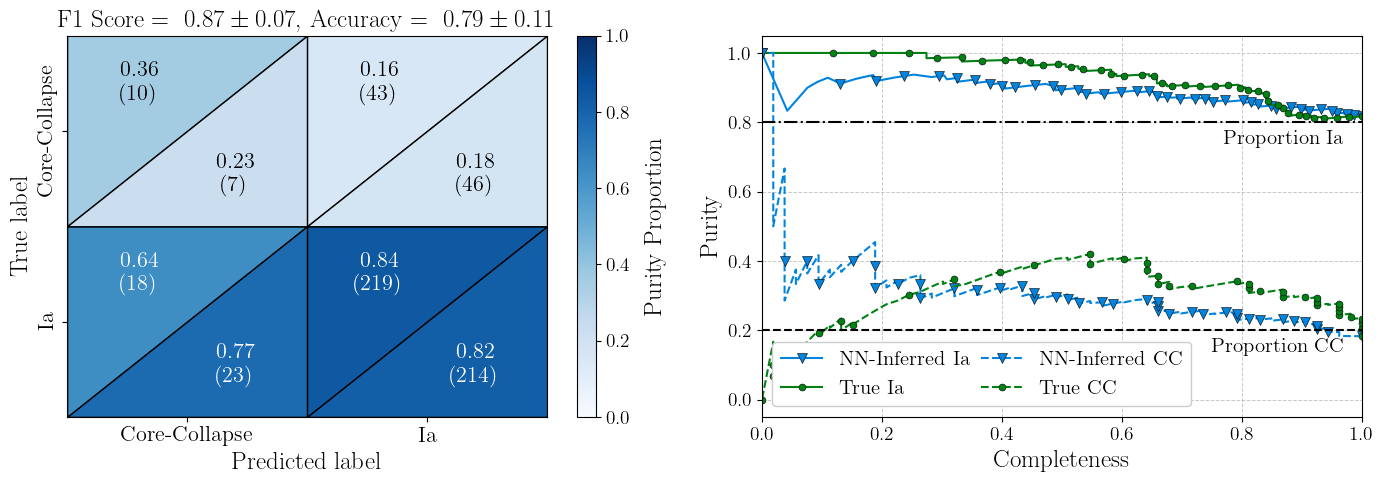

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)
fs=18

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=fs-2, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=fs-2, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Core-Collapse", "Ia"])
# ax1.set_yticklabels(["Ia", "Core-Collapse"], which='major', rotation=90)
ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=fs-2)  # Adjust labelsize as needed
# ax1.tick_params(axis='y', which='major', rotation=90)  # Adjust labelsize as needed
# ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
# ax1.major_ticklabels.set_va("center")


# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=fs)
ax1.set_xlabel('Predicted label', fontsize=fs)
ax1.set_title(rf'F1 Score$\ =\ {np.mean(f1_scores):.2f}\pm {np.std(f1_scores):.2f}$, Accuracy$\ =\ {np.mean(accuracies):.2f}\pm {np.std(accuracies):.2f}$', fontsize=fs)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=fs)
cbar.ax.tick_params(labelsize=fs-4)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred CC', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True CC', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', color='k')
ax2.text(1-0.03, naive_model-0.02, 'Proportion Ia', horizontalalignment='right', verticalalignment='top', fontsize=fs-3)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', color='k')
ax2.text(1-0.03, naive_model-0.02, 'Proportion CC', horizontalalignment='right', verticalalignment='top', fontsize=fs-3)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
ax2.tick_params(axis='both', which='major', labelsize=fs-4)  # Adjust labelsize as needed

# Format
ax2.set_xlabel('Completeness', fontsize=fs)
ax2.set_ylabel('Purity', fontsize=fs)
ax2.set_xlim((0, 1))
# ax2.legend(fancybox=True, ncol=3, framealpha=1, facecolor='white', loc='lower center', bbox_to_anchor=(0.5, 1.0), fontsize=fs-3, columnspacing=0.5)
ax2.legend(fancybox=True, ncol=2, framealpha=1, facecolor='white', loc='lower left', fontsize=fs-3, columnspacing=0.5)
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/Figures/final_k_fold_results.pdf', bbox_inches='tight')
plt.show()

# PanSTARRS

## Infer properties

In [5]:
def propocess_tab(table: ascii.Tab) -> pd.DataFrame:

    # Make and format a pd dataframe
    df: pd.DataFrame = table.to_pandas()
    column_types = {col: float for col in df.columns[:-2]}
    column_types[df.columns[-2]] = str
    column_types[df.columns[-1]] = float
    df = df.astype(column_types)
    df.replace('nan', np.nan, inplace=True)

    # The columns of grizy mags
    sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

    # Drop rows where the specified columns have more than 4 NaN values
    orig_len = len(df)
    df = df.dropna(thresh=3, subset=sed_cols, ignore_index=True)
    df = df.dropna(subset=['sn_class'], ignore_index=True)
    print(f'Dropped {orig_len - len(df)}/{orig_len} rows due to missingness. Now have {len(df)}')

    # Apply the function to each row
    df['angular_separation_arcsec'] = df.apply(lambda row: get_angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec']), axis=1)

    return df

In [6]:
# Get the preprocessed pstar data
panstarr_tab = ascii.read("/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts_pcc_final.ecsv", delimiter=' ', format='ecsv')
panstarr_df = propocess_tab(panstarr_tab)

Dropped 683/10090 rows due to missingness. Now have 9407


In [7]:
pstar_photo_mag = panstarr_df[['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi']].to_numpy()
pstar_photo_err_mag = panstarr_df[['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi']].to_numpy()

In [8]:
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

# Convert the data from mags to flux
pstar_photo = ab_mag_to_flux(pstar_photo_mag)
pstar_photo_err = ab_magerr_to_ferr(pstar_photo_err_mag, pstar_photo)

In [9]:
# Impute missing data
pstar_photo_imputed = np.isnan(pstar_photo)
photo_imputer = KNNImputer(n_neighbors=5)
photoerr_imputer = KNNImputer(n_neighbors=5)
pstar_photo = photo_imputer.fit_transform(pstar_photo)
pstar_photo_err = photoerr_imputer.fit_transform(pstar_photo_err)
pstar_photo_copy, pstar_photo_err_copy = np.copy(pstar_photo), np.copy(pstar_photo_err)

In [10]:
photo_imputer.indicator_

In [ ]:
with open('/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/trained_models/knn_imputers.pkl', 'wb') as f:
    pickle.dump((photo_imputer, photoerr_imputer), f)

In [11]:
# Apply log transform to the SEDs
pstar_photo_err = np.abs(pstar_photo_err / (pstar_photo * np.log(10)))
pstar_photo = np.log10(pstar_photo)

# Normalize data
pstar_photo_norm, pstar_photo_mean, pstar_photo_std, pstar_photo_err_norm = normalize_arr(pstar_photo, errors=pstar_photo_err, mean=photo_mean[:5], std=photo_std[:5])

In [12]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')
import importlib
import SPLASH
from SPLASH.pipeline import Splash_Pipeline
importlib.reload(SPLASH.pipeline)
from SPLASH.pipeline import Splash_Pipeline

pipeline = Splash_Pipeline(pipeline_version='full_band_no_photozs_zloss_grizy_weighted', pre_transformed=True, within_4sigma=False)
pstar_props_norm = pipeline.predict_host_properties(pstar_photo_norm, X_grizy_err=pstar_photo_err_norm, n_resamples=50, return_normalized=True)[0]

/Users/adamboesky/opt/anaconda3/envs/ay98_newskl/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNNImputer from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
classification_groups = [['ia'], ['ib', 'ic'], ['slsn'], ['iin'], ['ii', 'iip', 'ii p', 'iil', 'ii l']]

def add_sn_class_cols(df: pd.DataFrame) -> pd.DataFrame:
    # Ia or other
    ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in df['sn_class']], dtype=str)), 'ia') != -1
    df['sn_class_binary'] = ia_mask.astype(int)

    # Ia, II, or other
    # Conditions to check for 'ii' or 'ia' in a case-insensitive manner
    condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
    condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

    # Apply conditions and choices to the string array
    df['sn_class_tertiary'] = np.where(condition_ia(df['sn_class']), 0, np.where(condition_ii(df['sn_class']), 1, 2))

    # Your classification groups

    def add_category_id_column(my_df, classification_groups):
        # Convert classification groups to lowercase and assign unique integers to each category
        lowercase_groups = {cls.lower(): i for i, group in enumerate(classification_groups) for cls in group}

        # Function to get the category id for a supernova class
        def get_category_id(sn_class_list):
            for sn_class in sn_class_list:
                sn_class_lower = sn_class.lower()
                for group, group_id in lowercase_groups.items():
                    if group in sn_class_lower:
                        return group_id
            return np.max(list(lowercase_groups.values())) + 1  # Return a default id if no category is found

        # Add 'category_id' column to the DataFrame
        my_df['sn_class_cat'] = my_df['sn_class'].apply(lambda x: get_category_id(x.split(',')))

        return my_df

    # Apply the function to the DataFrame
    df = add_category_id_column(df, classification_groups)
    for idx, snt in enumerate(('ia', 'ib/c', 'slsn', 'iin', 'ii (p/l)')):
        print(f'The data are {np.round(len(df[df["sn_class_cat"] == idx]) / len(df) * 100, 2)}% type {snt} with n = {len(df[df["sn_class_cat"] == idx])}')

    return df

In [14]:
# Add columns that denote the SN classes
panstarr_df = add_sn_class_cols(panstarr_df)
panstarr_df['angular_separation_arcsec'] = get_angular_separation(panstarr_df['raStack_3pi'], panstarr_df['decStack_3pi'], panstarr_df['SN_ra'], panstarr_df['SN_dec'], unit1='deg', unit2='deg')
panstarr_df

The data are 68.28% type ia with n = 6423
The data are 6.96% type ib/c with n = 655
The data are 0.84% type slsn with n = 79
The data are 2.77% type iin with n = 261
The data are 16.57% type ii (p/l) with n = 1559


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,1.839010e+17,101.257336,63.249727,1.0,20.2123,19.4741,19.6845,19.6740,19.7830,0.024837,...,0.093262,0.000000,101.257000,63.249972,II P,NaN,1.036981,0,1,4
1,8.326343e+16,343.097793,-20.610464,1.0,16.2329,15.8255,15.6137,15.5744,15.3857,0.002976,...,0.007104,0.132961,343.097708,-20.614917,Ia,0.033150,16.031356,1,0,0
2,1.479104e+17,35.504167,33.266051,1.0,12.5022,11.7593,11.3363,11.3089,11.2106,0.000230,...,0.000387,0.236131,35.499917,33.270472,Ia,0.013269,20.419790,1,0,0
3,1.072924e+17,244.140958,-0.588824,1.0,16.1156,15.7253,15.5693,15.4091,15.2103,0.001789,...,0.004224,0.038113,244.141917,-0.590944,Ia,0.016460,8.378815,1,0,0
4,1.134624e+17,244.296033,4.554083,1.0,15.6716,14.9574,14.5674,14.3897,14.2283,0.001545,...,0.002459,0.155941,244.295875,4.554083,Ia,0.018000,0.565643,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,1.707714e+17,137.507912,52.315744,1.0,19.6314,19.2990,19.1074,19.1259,19.5551,0.016346,...,0.079351,0.000000,137.507750,52.315611,Ia,0.040000,0.598116,1,0,0
9403,1.281323e+17,225.325442,16.777947,1.0,15.4860,14.8218,14.3426,14.0982,13.8556,0.001806,...,0.002709,0.133899,225.329750,16.779972,Ia,0.050000,16.543153,1,0,0
9404,1.096604e+17,39.531415,1.388424,1.0,15.0879,15.9814,14.1134,13.9812,13.7094,0.002940,...,0.003266,0.186789,39.530375,1.391444,"IIb,II",0.022900,11.499092,0,1,1
9405,1.164508e+17,78.699637,7.048043,1.0,16.6697,15.7644,15.2988,14.9323,14.7282,0.002636,...,0.002772,0.083613,78.699167,7.050361,"Ia,Ia-91T,I",0.050500,8.510967,1,0,0


In [15]:
print('Non-Ia/Insufficient Classifications: ', panstarr_df['sn_class'][panstarr_df['sn_class_cat'] == 5].unique())

non_ia_class_df = panstarr_df[panstarr_df['sn_class_cat'] != 5]

Non-Ia/Insufficient Classifications:  ['removed' 'NT' 'Other' 'BL' 'other' 'Say1' 'I' 'Afterglow' 'LGRB' 'XRB'
 'BL,BL Lac' 'Jovan' 'CN' 'Radio' 'ILRT' 'Iz' 'I,TDE']


In [16]:
def filter_unique_multiple_categories(df, classification_groups):
    # Convert classification groups to lowercase
    lowercase_groups = [[cls.lower() for cls in group] for group in classification_groups]

    # Function to check if a class belongs to multiple unique categories
    def belongs_to_multiple_unique_categories(sn_class_list):
        categories_matched = set()
        for sn_class in sn_class_list:
            sn_class_lower = sn_class.lower()
            for i, group in enumerate(lowercase_groups):
                if sn_class_lower in group:
                    categories_matched.add(i)
                    break
        return len(categories_matched) > 1

    # Filter DataFrame with case insensitive comparison and handling comma-separated classes
    return df[df['sn_class'].apply(lambda x: belongs_to_multiple_unique_categories(x.split(',')))]

# Apply the function to the DataFrame
multiple_class_df = filter_unique_multiple_categories(panstarr_df, classification_groups)
print(len(multiple_class_df))
for i in range(len(multiple_class_df)):
    print(str(int(multiple_class_df['objID_3pi'].iloc[i])), '\t\t', multiple_class_df['sn_class'].iloc[i])

24
183901012573690336 		 Ia,II
115742251149866144 		 II,Ia,Ia-91bg
97853509906337936 		 IIn,II
109061678181601264 		 IIn?,II,IIn
102381528992336816 		 II,Ic
116612461763719584 		 IIn,II
98651839064753408 		 II,Ia,II P
115681448469792448 		 Ia,Ic
172272150455194752 		 IIn,II
203741971565915264 		 Ia,II,IIb
113870203451860704 		 II,IIn
147232446484447360 		 II,Ia
110382603003816400 		 Ic,Ia
142513462517664096 		 II,Ic
87792149356024656 		 II,IIn
189892330034466272 		 II,IIn
124432151791835856 		 II,Ia
160263258891031776 		 IIn,II
158891332359198784 		 IIn,II
98330267154683840 		 Ib,Ia
147030410013305760 		 Ia,Ic
127110585665664896 		 Ic,Ia
97410595434384944 		 IIn,II
156522473593907200 		 Ia,II


In [17]:
# Scale the properties by the Zou mean and std
pstar_props = pstar_props_norm * hp_cat_std + hp_cat_mean
pstar_props[:, 2] = 10**pstar_props[:, 2]

In [18]:
# Make a df
sne_df = pd.DataFrame(np.hstack((panstarr_df[['sn_class_cat', 'angular_separation_arcsec']], pstar_props)), columns=[r'Supernova Type', r'$\log(\rm{Separation})$ [$^{\prime\prime}$]', r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$]', r'Redshift'])
sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = pd.to_numeric(sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'], errors='coerce')
sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = np.log10(sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'])

# # Reorder for zorder
# sne_df = pd.concat([sne_df[sne_df[r'Supernova Type'] == 0], sne_df[sne_df[r'Supernova Type'] == 1], sne_df[sne_df[r'Supernova Type'] == 2]])

# Filter for everything predicted to be z \in [0, 1]
z_mask = (sne_df['Redshift'] < 1) & (sne_df['Redshift'] > 0)
print(np.sum(~z_mask), len(z_mask))

# Filter for within 4 stdevs of training data
within_training_mask = np.all((pstar_props_norm < 4) & (pstar_props_norm > -4), axis=1)
print(np.sum(~within_training_mask), len(within_training_mask))

0 9407
1208 9407


In [19]:
# Create a mask indicating whether each row in df1 is in the joined DataFrame
good_class_mask = ~panstarr_df.isin(multiple_class_df.to_dict(orient='list')).all(axis=1) & panstarr_df.isin(non_ia_class_df.to_dict(orient='list')).all(axis=1)
print(np.sum(~good_class_mask))

454


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_30233/1134567639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Supernova Type'] = df['Supernova Type'].astype(str).map(label_dict)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_30233/1134567639.py:19: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(len(numeric_columns), len(numeric_columns), figsize=(12, 11))
/Users/adamboesky/opt/anaconda3/envs/ay98_newskl/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/ay98_newskl/li

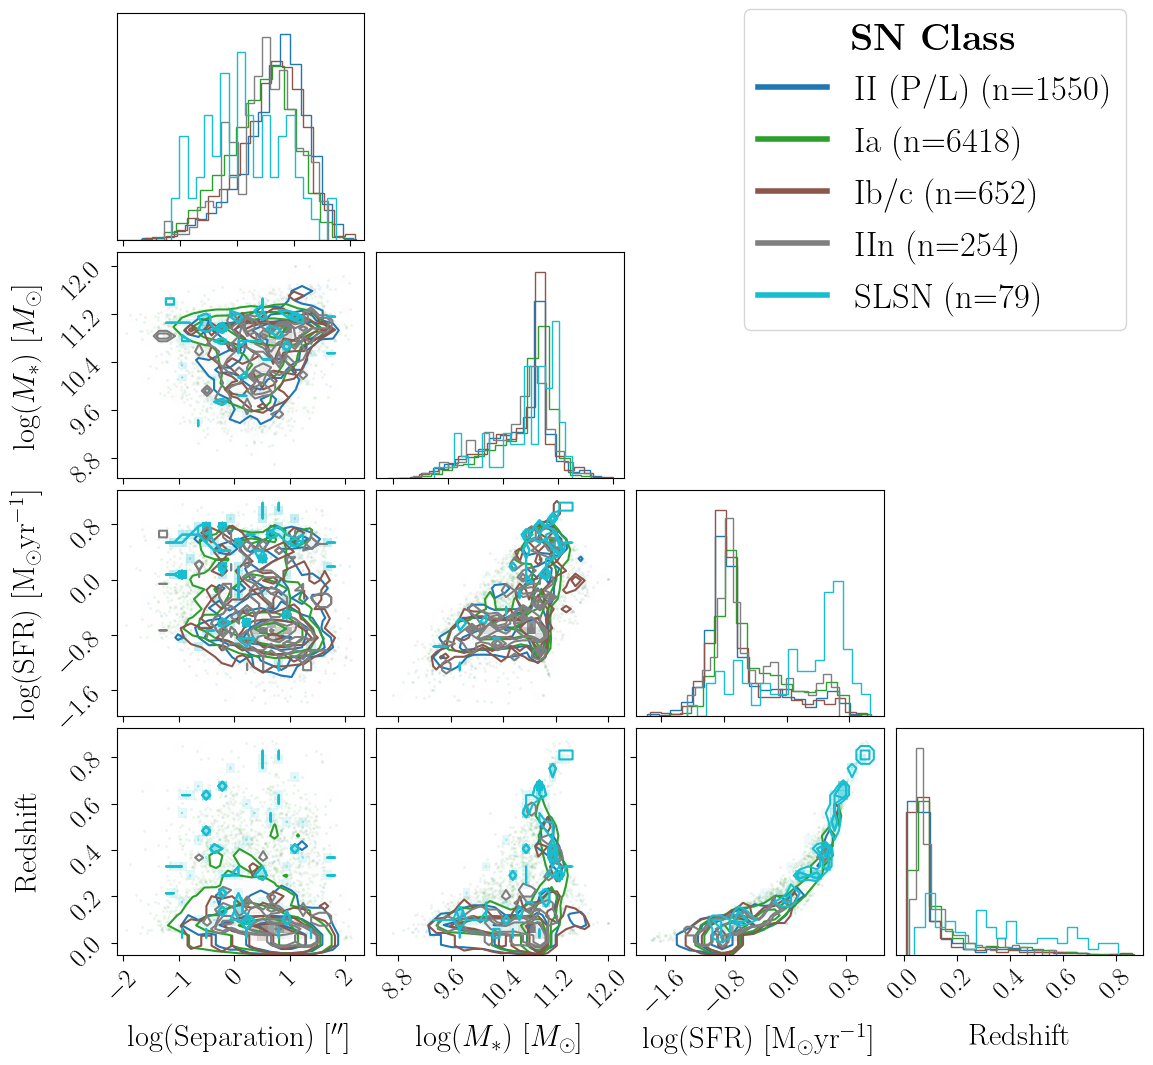

In [20]:
import corner

# Assuming 'sne_df' is your DataFrame and 'within_training_mask' & 'z_mask' are your conditions
df = sne_df[z_mask & good_class_mask]

# Update the DataFrame to use the label dictionary for 'Supernova Type'
label_dict = {'0.0': 'Ia', '1.0': 'Ib/c', '2.0': 'SLSN', '3.0': 'IIn', '4.0': 'II (P/L)'}
df['Supernova Type'] = df['Supernova Type'].astype(str).map(label_dict)

# Define colors for each type
colors = plt.cm.tab10(np.linspace(0, 1, len(df['Supernova Type'].unique())))

# Filter only numeric columns for plotting
numeric_columns = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
axis_labels = [col for col in numeric_columns]
label_kwargs = {'fontsize': 22, 'labelpad': -100}  # Adjust the labelpad as needed

# Create a figure
fig, axes = plt.subplots(len(numeric_columns), len(numeric_columns), figsize=(12, 11))

# Plot each subset separately with density histograms on the diagonal
for i, (supernova_type, color) in enumerate(zip(df['Supernova Type'].unique(), colors)):
    hist_kwargs = {'density': True, 'color': color}
    subset = df[df['Supernova Type'] == supernova_type][numeric_columns]
    corner_plot = corner.corner(subset, color=color, fig=fig, hist_kwargs=hist_kwargs, labels=axis_labels, label_kwargs=label_kwargs)

    # Color the histograms on the diagonal
    for j in range(len(numeric_columns)):
        ax = corner_plot.axes[j + len(numeric_columns) * j]
        for patch in ax.patches:
            patch.set_facecolor(color)

# Decrease the label padding
for ax in fig.axes:
    ax.xaxis.labelpad = -50
    ax.yaxis.labelpad = -50
    ax.tick_params(axis='both', which='major', labelsize=19, length=4)

# Customizing the plot appearance
# mpl.rcParams["legend.facecolor"] = '#F0F0F0'
# plt.subplots_adjust(right=0.85)
# plt.tight_layout()

# Adding a legend
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=supernova_type + f"     (n={len(df[df['Supernova Type'] == supernova_type])})") for supernova_type, color in zip(df['Supernova Type'].unique(), colors)]
plt.legend(handles=legend_elements, fontsize='25', bbox_to_anchor=(1, 4.245), frameon=True, title=r'\textbf{SN Class}', title_fontsize='27', facecolor='white', loc='upper right')
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/Figures/pstar_sne_corner.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Classifying

In [69]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)
# smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
binary_f1_scores = []
binary_accuracies = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_binary'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='macro')  # Adjust the 'average' parameter as needed
    accuracy = accuracy_score(y_test, y_pred)
    binary_f1_scores.append(f1)
    binary_accuracies.append(accuracy)

NameError: name 'best_max_depth' is not defined

In [30]:
print(f'f1_score = {np.mean(binary_f1_scores)}')
print(f'Accuracy = {(cumulative_cm[0,0] + cumulative_cm[1,1]) / (cumulative_cm[0,0] + cumulative_cm[0,1] + cumulative_cm[1,0] + cumulative_cm[1,1])}')

f1_score = 0.5989114959669384
Accuracy = 0.7298674821610601


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_51146/4225199050.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_51146/4225199050.py:71: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


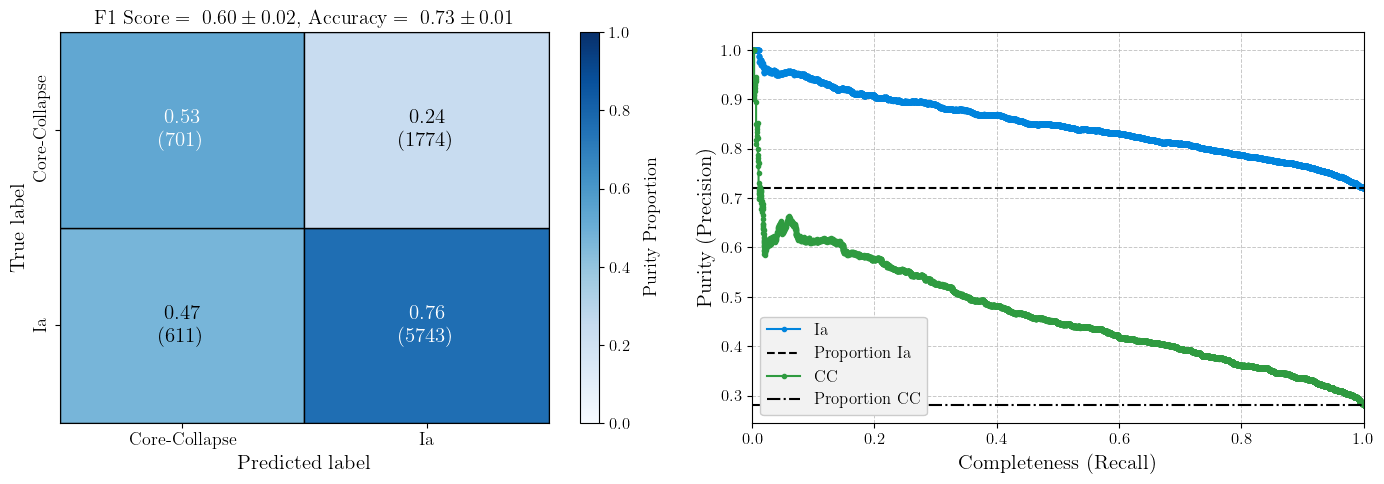

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Core-Collapse", "Ia"])
ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Add title with accuracy and f1 score
ax1.set_title(rf'F1 Score$\ =\ {np.mean(binary_f1_scores):.2f}\pm {np.std(binary_f1_scores):.2f}$, Accuracy$\ =\ {np.mean(binary_accuracies):.2f}\pm {np.std(binary_accuracies):.2f}$')

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)


# Ia
ax2.plot(sed_recall, sed_precision, marker='.', label='Ia', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='CC', color='#2F9B40')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion CC', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/panstarrs_classification_results.pdf', bbox_inches='tight')
plt.show()

In [32]:
# Initialize a matrix to hold the summed confusion matrix
cumulative_cm_sed_only = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_sed_only = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests_sed_only = []
y_proba_sed_only = []
f1_scores_sed_only = []

# X and y set
preds = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
pstar_sed_X = pstar_photo[within_training_mask & z_mask & good_class_mask]
pstar_sed_y = panstarr_df['sn_class_binary'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_sed_X, pstar_sed_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_sed_X[train_index], pstar_sed_X[test_index]
    y_train, y_test = pstar_sed_y[train_index], pstar_sed_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm_sed_only += confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests_sed_only.append(y_test)
    y_proba_sed_only.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='macro')  # Adjust the 'average' parameter as needed
    f1_scores_sed_only.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_51146/2243281030.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_51146/2243281030.py:77: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


Didn't concat


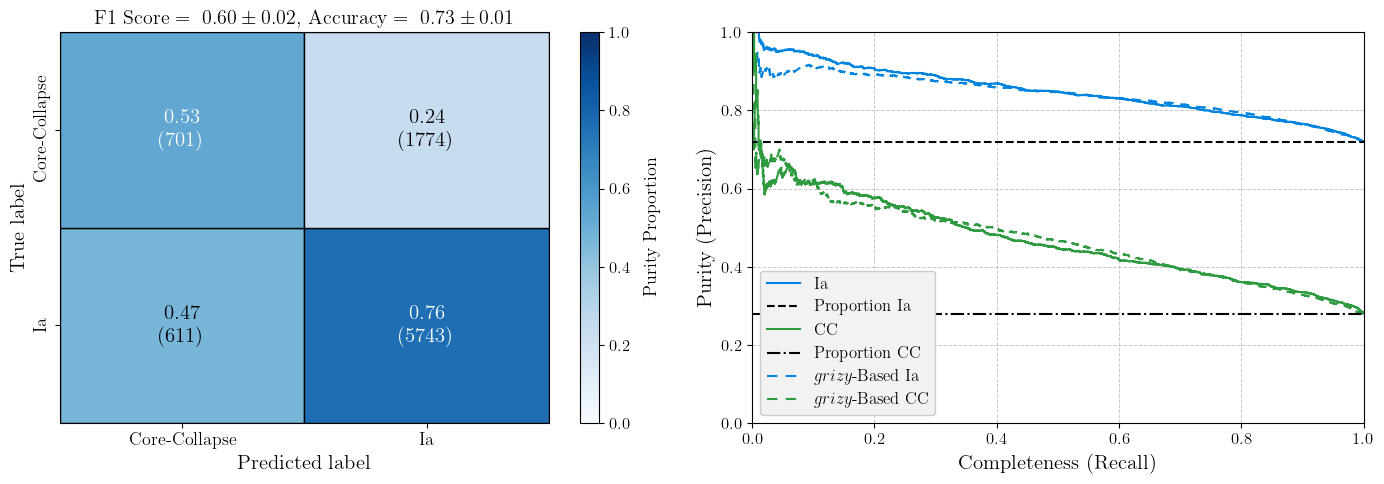

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

try:
    y_tests_sed_only = np.concatenate(y_tests_sed_only)
    y_proba_sed_only = np.concatenate(y_proba_sed_only)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)
sed_precision_sed_only, sed_recall_sed_only, thresholds_sed_only = precision_recall_curve(y_tests_sed_only, y_proba_sed_only)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
sed_precision_0_sed_only, sed_recall_0_sed_only, thresholds_0_sed_only = precision_recall_curve(y_tests_sed_only, 1 - y_proba_sed_only, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Core-Collapse", "Ia"])
ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_title(rf'F1 Score$\ =\ {np.mean(binary_f1_scores):.2f}\pm {np.std(binary_f1_scores):.2f}$, Accuracy$\ =\ {np.mean(binary_accuracies):.2f}\pm {np.std(binary_accuracies):.2f}$')

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)


# HOST-PROP CLASSIFICATIONS
# Ia
ax2.plot(sed_recall, sed_precision, label='Ia', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, label='CC', color='#2F9B40')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion CC', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
# SED ONLY CLASSIFICATIONS
line1 = ax2.plot(sed_recall_sed_only, sed_precision_sed_only, label=r'$grizy$-Based Ia', color='#0084DD', zorder=-1, linestyle='-')
line1[0].set_dashes([5, 4])  # Increase the spacing between dashes
# Non-Ia
line2 = ax2.plot(sed_recall_0_sed_only, sed_precision_0_sed_only, label=r'$grizy$-Based CC', color='#2F9B40', zorder=-1, linestyle='--')
line2[0].set_dashes([5, 4])  # Increase the spacing between dashes

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
ax2.legend(fancybox=True, loc='lower left', framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/panstarrs_classification_results.pdf', bbox_inches='tight')
plt.show()

In [69]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=20, random_state=22, shuffle=True)
rf_classifier_multi = RandomForestClassifier(n_estimators=1000, random_state=22)

# Initialize a matrix to hold the summed confusion matrix
multiclass_cumulative_cm = np.array([[0 for _ in range(5)] for _ in range(5)])
multiclass_cumulative_cm_8 = np.array([[0 for _ in range(5)] for _ in range(5)])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
multiclass_f1_scores = []
multiclass_accuracies = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
# pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
# pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()
custom_thresholds = [0.6, 0.7, 0.8, 0.9]  # Modify this value to control the threshold
multiclass_cumulative_cm_thresh = {thresh: np.array([[0 for _ in range(5)] for _ in range(5)]) for thresh in custom_thresholds}

# Initialize lists of the scores for the purity vs. completeness graphs
multiclass_f1_scores_thresh = {thresh: [] for thresh in custom_thresholds}
multiclass_accuracies_thresh = {thresh: [] for thresh in custom_thresholds}

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi.fit(X_train, y_train)
    y_pred = rf_classifier_multi.predict(X_test)
    multiclass_cumulative_cm += confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi.predict_proba(X_test)
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='macro')  # Adjust the 'average' parameter as needed
    accuracy = accuracy_score(y_test, y_pred)
    multiclass_f1_scores.append(f1)
    multiclass_accuracies.append(accuracy)


    # Apply the custom threshold to class probabilities
    y_pred_custom = np.zeros_like(y_pred)
    for thresh in custom_thresholds:
        for i, proba in enumerate(y_pred_proba):
            y_pred_custom[i] = np.argmax(proba) if np.max(proba) >= thresh else -1  # Use -1 for no class prediction

        # Calculate confusion matrix for threshold-based completeness
        valid_indices = y_pred_custom != -1  # Only include valid predictions
        multiclass_cumulative_cm_thresh[thresh] += confusion_matrix(y_test[valid_indices], y_pred_custom[valid_indices], labels=[i for i in range(5)])

        f1 = f1_score(y_test[valid_indices], y_pred_custom[valid_indices], average='macro')  # Adjust the 'average' parameter as needed
        accuracy = accuracy_score(y_test[valid_indices], y_pred_custom[valid_indices])
        multiclass_f1_scores_thresh[thresh].append(f1)
        multiclass_accuracies_thresh[thresh].append(accuracy)

In [39]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=20, random_state=22, shuffle=True)
rf_classifier_multi_balanced = RandomForestClassifier(n_estimators=1000, random_state=22, class_weight='balanced')

# Initialize a matrix to hold the summed confusion matrix
multiclass_cumulative_cm_balanced = np.array([[0 for _ in range(5)] for _ in range(5)])
custom_thresholds = [0.6, 0.7, 0.8, 0.9]  # Modify this value to control the threshold
multiclass_cumulative_cm_balanced_thresh = {thresh: np.array([[0 for _ in range(5)] for _ in range(5)]) for thresh in custom_thresholds}

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests_balanced = []
y_proba_balanced = []
multiclass_f1_scores_balanced = []
multiclass_accuracies_balanced = []
multiclass_f1_scores_balanced_thresh = {thresh: [] for thresh in custom_thresholds}
multiclass_accuracies_balanced_thresh = {thresh: [] for thresh in custom_thresholds}

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
# pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
# pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi_balanced.fit(X_train, y_train)
    y_pred = rf_classifier_multi_balanced.predict(X_test)
    multiclass_cumulative_cm_balanced += confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi_balanced.predict_proba(X_test)
    y_tests_balanced.append(y_test)
    y_proba_balanced.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='macro')  # Adjust the 'average' parameter as needed
    accuracy = accuracy_score(y_test, y_pred)
    multiclass_f1_scores_balanced.append(f1)
    multiclass_accuracies_balanced.append(accuracy)


    # Apply the custom threshold to class probabilities
    y_pred_custom = np.zeros_like(y_pred)
    for thresh in custom_thresholds:
        for i, proba in enumerate(y_pred_proba):
            y_pred_custom[i] = np.argmax(proba) if np.max(proba) >= thresh else -1  # Use -1 for no class prediction

        # Calculate confusion matrix for threshold-based completeness
        valid_indices = y_pred_custom != -1  # Only include valid predictions
        multiclass_cumulative_cm_balanced_thresh[thresh] += confusion_matrix(y_test[valid_indices], y_pred_custom[valid_indices], labels=[i for i in range(5)])

        f1 = f1_score(y_test[valid_indices], y_pred_custom[valid_indices], average='macro')  # Adjust the 'average' parameter as needed
        accuracy = accuracy_score(y_test[valid_indices], y_pred_custom[valid_indices])
        multiclass_f1_scores_balanced_thresh[thresh].append(f1)
        multiclass_accuracies_balanced_thresh[thresh].append(accuracy)

In [45]:
three_class_preds = np.argmax(np.vstack(y_proba), axis=1)
three_class_preds[three_class_preds == 3] = 2
three_class_preds[three_class_preds == 4] = 2
three_class_ytests = np.copy(np.hstack(y_tests))
three_class_ytests[three_class_ytests == 3] = 2
three_class_ytests[three_class_ytests == 4] = 2

f1_score(three_class_preds, three_class_ytests, average='macro')

0.36384209291702163

In [46]:
# Initialize a matrix to hold the summed confusion matrix
cumulative_cm_sed_only = np.array([[0 for _ in range(5)] for _ in range(5)])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests_sed_only = []
y_proba_sed_only = []
f1_scores_sed_only = []

# X and y set
preds = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
pstar_sed_X = pstar_photo[within_training_mask & z_mask & good_class_mask]
pstar_sed_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

# pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
# pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_X = panstarr_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()
# Iterate over each fold
for train_index, test_index in kf.split(pstar_sed_X, pstar_sed_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_sed_X[train_index], pstar_sed_X[test_index]
    y_train, y_test = pstar_sed_y[train_index], pstar_sed_y[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi.fit(X_train, y_train)
    y_pred = rf_classifier_multi.predict(X_test)
    cumulative_cm_sed_only += confusion_matrix(y_test, y_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi.predict_proba(X_test)
    y_tests_sed_only.append(y_test)
    y_proba_sed_only.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='macro')  # Adjust the 'average' parameter as needed
    f1_scores_sed_only.append(f1)

In [47]:
print(rf'F1 Score$\ =\ {np.mean(multiclass_f1_scores):.2f}\pm {np.std(multiclass_f1_scores):.2f}$, Accuracy$\ =\ {np.mean(multiclass_accuracies):.2f}\pm {np.std(multiclass_accuracies):.2f}$')
print(rf'F1 Score$\ =\ {np.mean(multiclass_f1_scores_balanced):.2f}\pm {np.std(multiclass_f1_scores_balanced):.2f}$, Accuracy$\ =\ {np.mean(multiclass_accuracies_balanced):.2f}\pm {np.std(multiclass_accuracies_balanced):.2f}$')

F1 Score$\ =\ 0.23\pm 0.02$, Accuracy$\ =\ 0.69\pm 0.01$
F1 Score$\ =\ 0.22\pm 0.02$, Accuracy$\ =\ 0.70\pm 0.01$


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/2891134559.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/2891134559.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


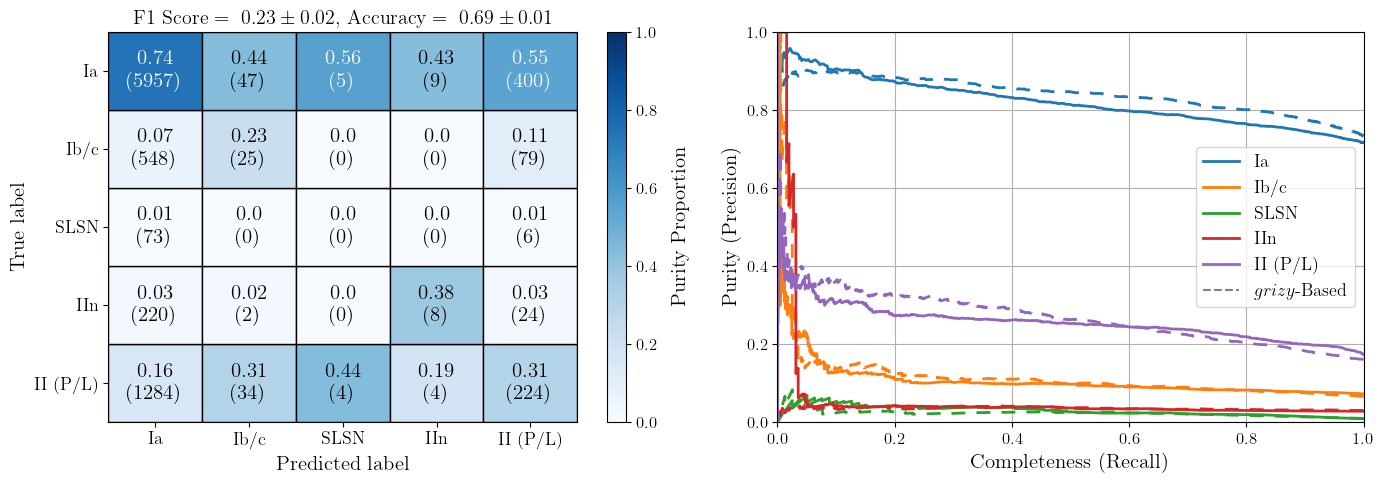

In [51]:
# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(multiclass_cumulative_cm)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_title(rf'F1 Score$\ =\ {np.mean(multiclass_f1_scores):.2f}\pm {np.std(multiclass_f1_scores):.2f}$, Accuracy$\ =\ {np.mean(multiclass_accuracies):.2f}\pm {np.std(multiclass_accuracies):.2f}$')

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Concatenate the arrays in y_tests and y_proba
# if y_tests.ndim != 1:
y_tests_concatenated = np.concatenate(y_tests)
y_proba_concatenated = np.concatenate(y_proba, axis=0)
# if y_tests_sed_only.ndim != 1:
y_tests_sed_only_concatenated = np.concatenate(y_tests_sed_only)
y_proba_sed_only_concatenated = np.concatenate(y_proba_sed_only, axis=0)

# Ensure y_proba_concatenated is a 2D array
if y_proba_concatenated.ndim == 1:
    y_proba_concatenated = y_proba_concatenated.reshape(-1, 1)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (y_tests_concatenated == i)
    proba_binary = y_proba_concatenated[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

    # Treat class i as the positive class
    true_binary = (y_tests_sed_only_concatenated == i)
    proba_binary = y_proba_sed_only_concatenated[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    line = ax2.plot(recall, precision, color=color, lw=2)
    line[0].set_dashes([5, 4])  # Increase the spacing between dashes

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
grizy = mlines.Line2D([], [], color='gray', linestyle='--', label=r'$grizy$-Based')
handles, labels = ax2.get_legend_handles_labels()
handles.append(grizy)
ax2.legend(handles=handles, fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()

In [71]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22)

# Initialize a matrix to hold the summed confusion matrix
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
cumulative_cm_balaned = {class_lab: np.array([[0, 0], [0, 0]]) for class_lab in class_labels}
cumulative_cm_balanced_thresh = {thresh: {class_lab: np.array([[0, 0], [0, 0]]) for class_lab in class_labels} for thresh in custom_thresholds}

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
# pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
# pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    for class_i, class_lab in enumerate(class_labels):

        # Make data into class v. other
        y_class = (pstar_y == class_i).astype(int)

        # Split the data into training and test sets for the current fold
        X_train, X_test = pstar_X[train_index], pstar_X[test_index]
        y_train, y_test = y_class[train_index], y_class[test_index]

        # Fit and get confusion matrix
        rf_classifier.fit(X_train, y_train)
        y_pred = rf_classifier.predict(X_test)
        y_pred_proba = rf_classifier.predict_proba(X_test)
        cumulative_cm_balaned[class_lab] += confusion_matrix(y_test, y_pred, labels=[0, 1])

        # Apply the custom threshold to class probabilities
        y_pred_custom = np.zeros_like(y_pred)
        for thresh in custom_thresholds:
            for i, proba in enumerate(y_pred_proba):
                y_pred_custom[i] = np.argmax(proba) if np.max(proba) >= thresh else -1

            # Calculate confusion matrix for threshold-based completeness
            valid_indices = y_pred_custom != -1
            cumulative_cm_balanced_thresh[thresh][class_lab] += confusion_matrix(y_test[valid_indices], y_pred_custom[valid_indices], labels=[0, 1])
            

In [59]:
def plot_binary_cm(ax, cm, lab):

    # Choose a colormap
    cmap = plt.cm.Blues

    # Define the bounds of the boxes
    bounds = [0, 1, 2]

    # Create a mesh grid
    X, Y = np.meshgrid(bounds, bounds)

    # Get the confusion normalized matrices
    cm1 = np.flipud(cm)
    cm1_col_norms = np.sum(cm1, axis=0)
    cm1_norm = cm1 / cm1_col_norms
    cm1_norm = cm1_norm.round(2)
    cm1_norm[np.isnan(cm1_norm)] = 0

    # Normalize the values for the colormap
    norm = plt.Normalize(vmin=0, vmax=1)

    for (i, j), z in np.ndenumerate(cm1):
        # Color for the top triangle (cm1)
        color1 = cmap(norm(cm1_norm[i, j]))

        # Split each cell diagonally
        ax.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

        # Add text
        if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
        else: col1 = 'k'
        if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
        else: col2 = 'k'
        ax.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

    # Set the limits and labels
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(["Other", lab])
    ax.set_yticklabels([lab, "Other"], rotation=90, va='center', ha='right')
    ax.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

    # Add grid, labels and title
    ax.grid(False)
    # ax.set_ylabel('True label', fontsize=15)
    # ax.set_xlabel('Predicted label', fontsize=15)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/113654521.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax1 = plt.subplot(gs[:, :3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/113654521.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax2 = plt.subplot(gs[0, 3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/113654521.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax3 = plt.subplot(gs[0, 4])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/113654521.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax4 = plt.subplot(gs[1, 3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/113654521.py:8: UserWarning: cmr10 font should ideally be used with mathtext, set 

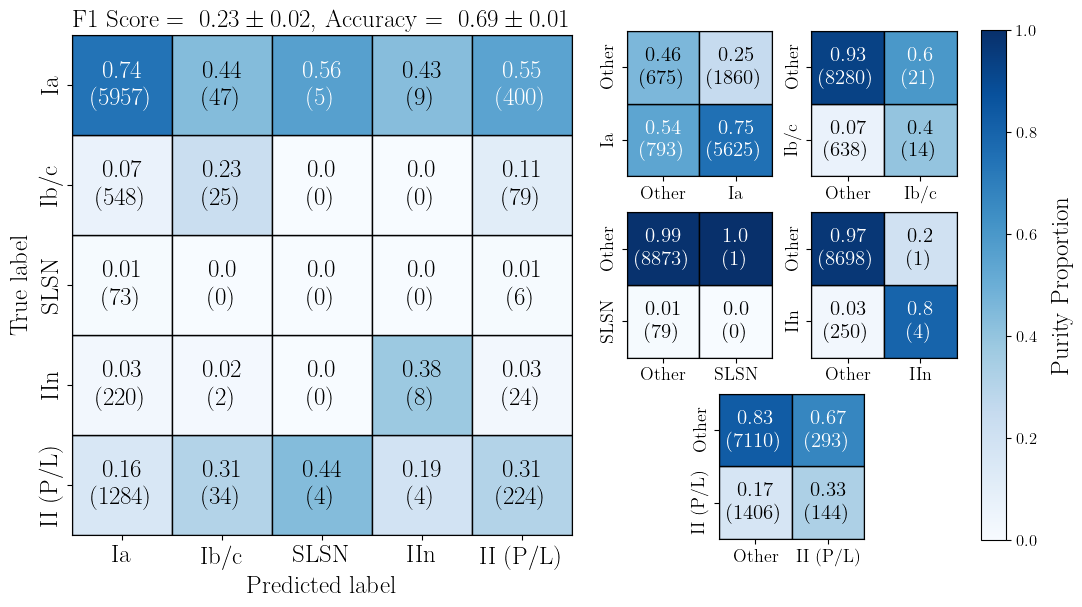

In [72]:
# Create figure, adjust figsize to ensure squareness
fig = plt.figure(figsize=(9.7, 6))
gs = gridspec.GridSpec(3, 5, figure=fig)
ax1 = plt.subplot(gs[:, :3])
ax2 = plt.subplot(gs[0, 3])
ax3 = plt.subplot(gs[0, 4])
ax4 = plt.subplot(gs[1, 3])
ax5 = plt.subplot(gs[1, 4])
ax6 = plt.subplot(gs[2, 3])

# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
fs = 18
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(multiclass_cumulative_cm)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=fs, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=fs)
ax1.set_ylabel('True label', fontsize=fs)
ax1.set_title(rf'F1 Score$\ =\ {np.mean(multiclass_f1_scores):.2f}\pm {np.std(multiclass_f1_scores):.2f}$, Accuracy$\ =\ {np.mean(multiclass_accuracies):.2f}\pm {np.std(multiclass_accuracies):.2f}$', fontsize=fs)

for ax, lab in zip([ax2, ax3, ax4, ax5, ax6], class_labels):
    plot_binary_cm(ax, cumulative_cm_balaned[lab], lab)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_aspect('equal')

cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)

plt.tight_layout(pad=0.7)
new_x0 = 0.5 * (ax4.get_position().x0 + ax5.get_position().x0)
current_pos = ax6.get_position()
ax6.set_position([new_x0, current_pos.y0, current_pos.width, current_pos.height])
cbar = plt.colorbar(sm, ax=ax1, anchor=(9.1, 0.5), pad=-0.12)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=fs)
plt.savefig('Figures/all_class_cm.pdf', bbox_inches='tight')
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/3581783906.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax1 = plt.subplot(gs[bottom_row:top_row, :3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/3581783906.py:11: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax2 = plt.subplot(gs[bottom_row, 3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/3581783906.py:12: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax3 = plt.subplot(gs[bottom_row, 4])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/3581783906.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax4 = plt.subplot(gs[bottom_row + 1, 3])
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_21342/3581783906.py:14: UserWarn

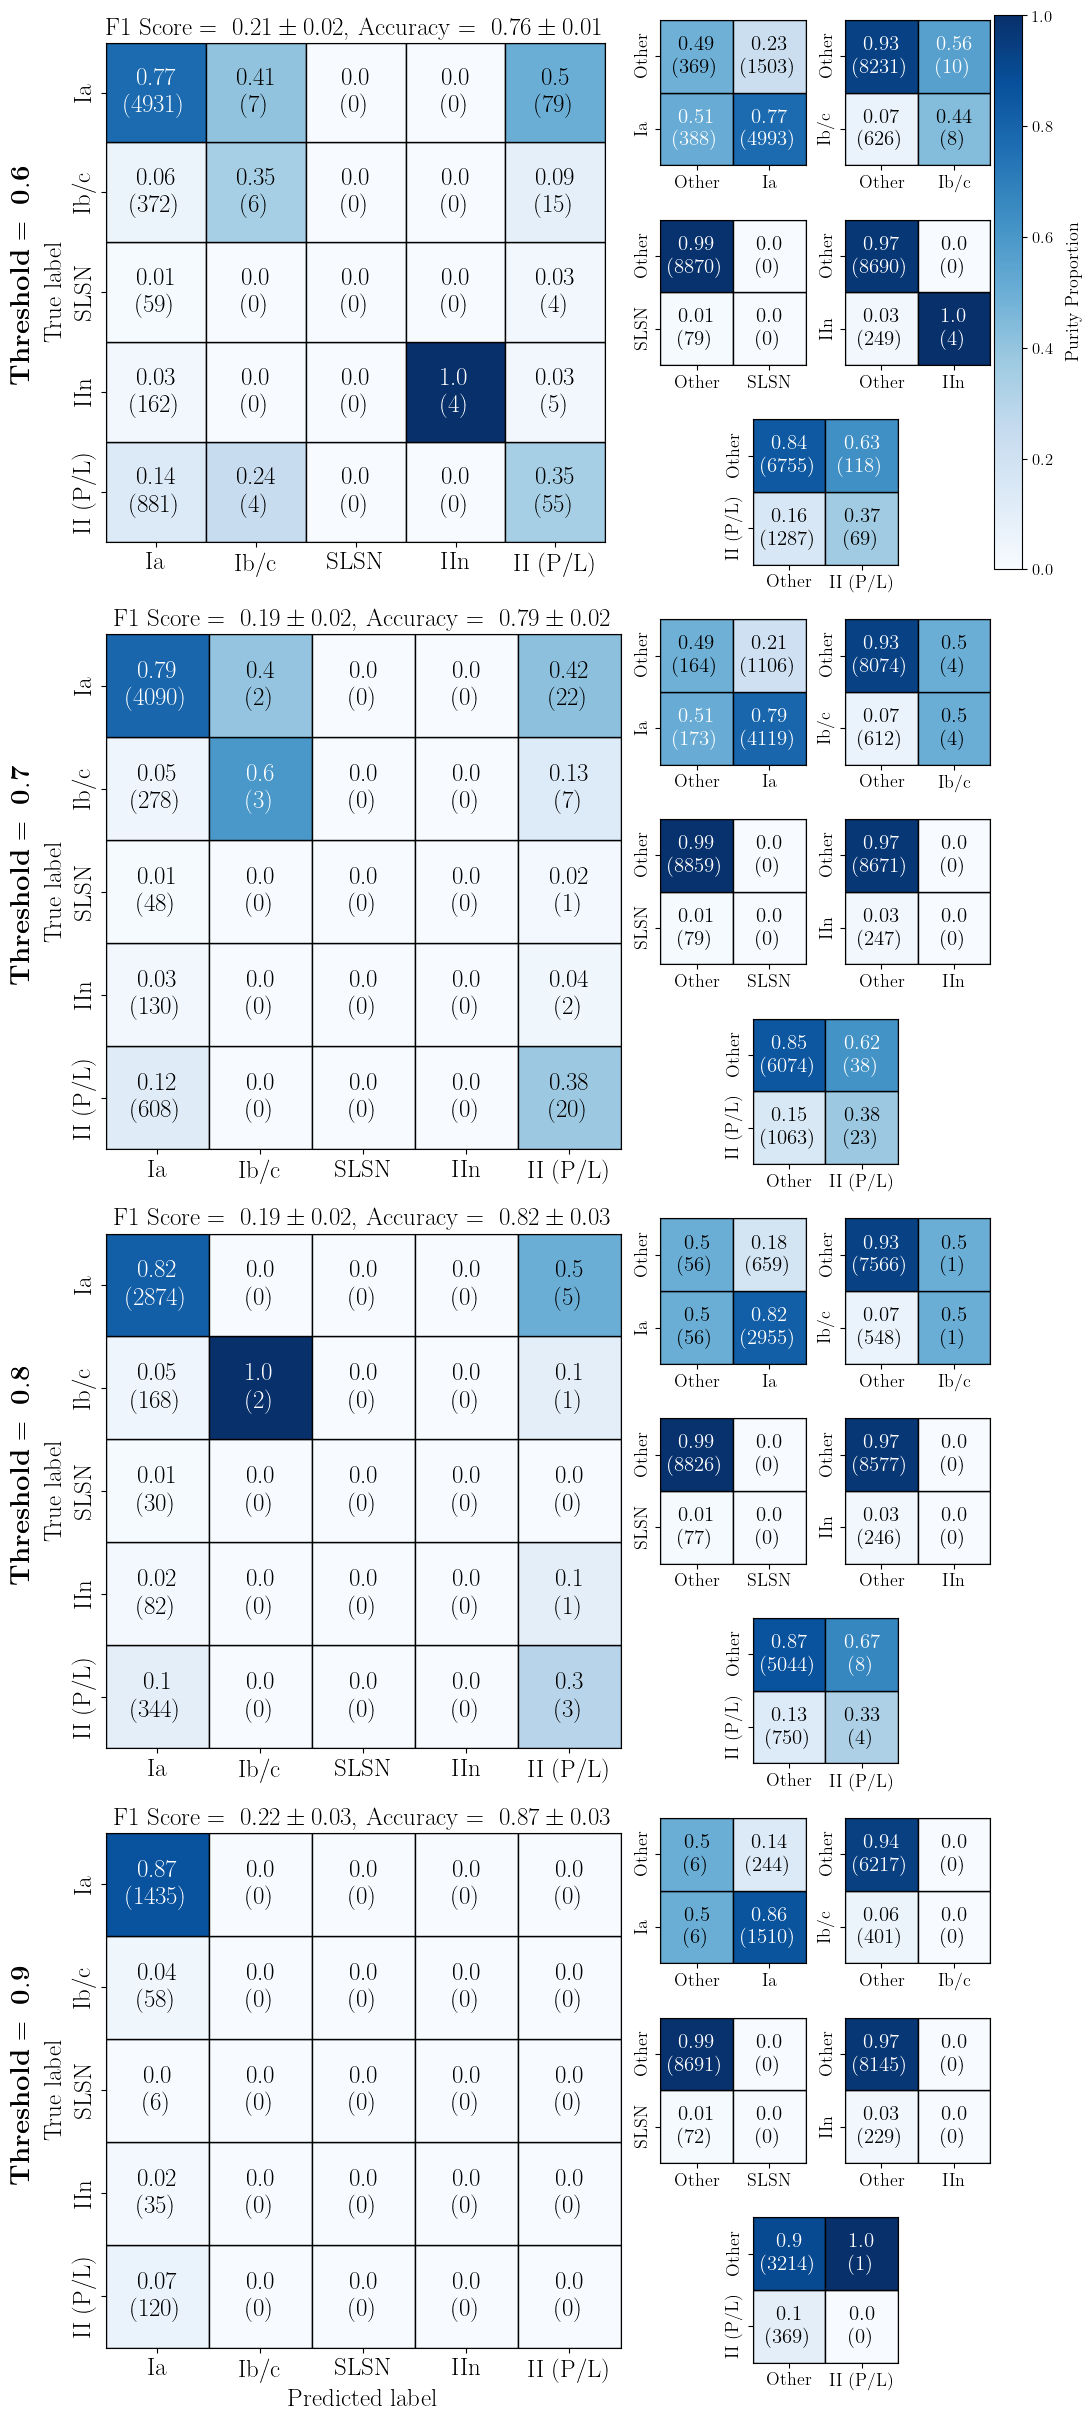

In [75]:
# Create figure, adjust figsize to ensure squareness
fig = plt.figure(figsize=(9.7, 24))
gs = gridspec.GridSpec(12, 5, figure=fig)

for i, thresh in enumerate(custom_thresholds):

    # Set up axes
    bottom_row = i * 3
    top_row = bottom_row + 3
    ax1 = plt.subplot(gs[bottom_row:top_row, :3])
    ax2 = plt.subplot(gs[bottom_row, 3])
    ax3 = plt.subplot(gs[bottom_row, 4])
    ax4 = plt.subplot(gs[bottom_row + 1, 3])
    ax5 = plt.subplot(gs[bottom_row + 1, 4])
    ax6 = plt.subplot(gs[bottom_row + 2, 3])

    # Add some space


    # Assuming cumulative_cm is a 5x5 confusion matrix
    # Update the colormap bounds and create a mesh grid for 5 classes
    fs = 18
    bounds = np.arange(6)
    X, Y = np.meshgrid(bounds, bounds)

    # Normalize the confusion matrix
    cm1 = np.flipud(multiclass_cumulative_cm_thresh[thresh])
    cm1_col_norms = np.sum(cm1, axis=0)
    cm1_norm = cm1 / cm1_col_norms
    cm1_norm = cm1_norm.round(2)
    cm1_norm[np.isnan(cm1_norm)] = 0

    # Plotting the confusion matrix
    cmap = plt.cm.Blues
    norm = plt.Normalize(vmin=0, vmax=1)

    for (ik, j), z in np.ndenumerate(cm1_norm):
        color = cmap(norm(z))
        ax1.fill_between([j, j+1], [ik, ik], [ik+1, ik+1], color=color, edgecolor='black')
        text_color = 'white' if z > 0.5 else 'black'
        ax1.text(j + 0.5, ik + 0.5, f'{z}\n({cm1[ik, j]})', ha='center', va='center', fontsize=fs, color=text_color)

    # Set the limits and labels for 5 classes
    class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0, 5)
    ax1.set_xticks(np.arange(0.5, 5.5))
    ax1.set_yticks(np.arange(0.5, 5.5))
    ax1.set_xticklabels(class_labels)
    ax1.set_yticklabels(class_labels[::-1], rotation=90, va='center', ha='right')
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax1.grid(False)
    if i == 3:
        ax1.set_xlabel('Predicted label', fontsize=fs)

    ax1.set_ylabel('True label', fontsize=fs)
    ax1.set_title(rf'F1 Score$\ =\ {np.mean(multiclass_f1_scores_thresh[thresh]):.2f}\pm {np.std(multiclass_f1_scores_thresh[thresh]):.2f}$, Accuracy$\ =\ {np.mean(multiclass_accuracies_thresh[thresh]):.2f}\pm {np.std(multiclass_accuracies_thresh[thresh]):.2f}$', fontsize=fs)

    # Add centered title with the threshold value
    fig.text(-0.01, (top_row + bottom_row - 1) / 24.0, rf'\textbf{{Threshold}}$\mathbf{{\ =\ {custom_thresholds[::-1][i]}}}$', ha='center', fontsize=fs + 2, weight='bold', rotation=90)

    for ax, lab in zip([ax2, ax3, ax4, ax5, ax6], class_labels):
        plot_binary_cm(ax, cumulative_cm_balanced_thresh[thresh][lab], lab)

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_aspect('equal')

    cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)

    plt.tight_layout(pad=0.7)
    new_x0 = 0.5 * (ax4.get_position().x0 + ax5.get_position().x0)
    current_pos = ax6.get_position()
    ax6.set_position([new_x0, current_pos.y0, current_pos.width, current_pos.height])

    if i == 0:
        cbar = plt.colorbar(sm, ax=ax1, anchor=(9.1, 0.5), pad=-0.12)
        cbar.set_label('Purity Proportion', labelpad=10, fontsize=fs+2)

plt.savefig('Figures/all_class_cm_by_thresh.pdf', bbox_inches='tight')
plt.show()

In [21]:
import bz2
from sklearn.calibration import CalibratedClassifierCV

preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()

# Get calibration data
X_train, X_calib, y_train, y_calib = train_test_split(pstar_X, pstar_y, random_state=22)

# Train and save the model
final_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, class_weight='balanced')
final_classifier.fit(X_train, y_train)

# Calibrate
calibrated_clf = CalibratedClassifierCV(final_classifier, cv="prefit")
calibrated_clf.fit(X_calib, y_calib)

# with open('rf_classifier.pkl', 'wb') as f:
#     pickle.dump(final_classifier, f)

# with bz2.BZ2File('/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/trained_models/rf_classifier_old_version.pbz2', 'wb') as f:
#     pickle.dump(calibrated_clf, f)

with bz2.BZ2File('/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/trained_models/rf_classifier_new_version.pbz2', 'wb') as f:
    pickle.dump(final_classifier, f)

In [31]:
from sklearn.calibration import CalibratedClassifierCV

In [22]:
import bz2

# Initialize a matrix to hold the summed confusion matrix
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
cumulative_cm = {class_lab: np.array([[0, 0], [0, 0]]) for class_lab in class_labels}

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()

for class_i, class_lab in enumerate(class_labels):

    # Make data into class v. other
    y_class = (pstar_y == class_i).astype(int)

    # Get calibration data
    X_train, X_calib, y_train, y_calib = train_test_split(pstar_X, y_class, random_state=22)

    # Fit and get confusion matrix
    final_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, class_weight='balanced')
    final_classifier.fit(X_train, y_train)

    # Calibrate
    calibrated_clf = CalibratedClassifierCV(final_classifier, cv="prefit")
    calibrated_clf.fit(X_calib, y_calib)

    # with bz2.BZ2File(f"/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/trained_models/ovr_rfs/old_skl/{class_lab.lower().replace(' ', '_').replace('/', '&').replace('i', 'I')}_rf.pbz2", 'wb') as f:
    #     pickle.dump(calibrated_clf, f)

    with bz2.BZ2File(f"/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/trained_models/ovr_rfs/new_skl/{class_lab.lower().replace(' ', '_').replace('/', '&').replace('i', 'I')}_rf.pbz2", 'wb') as f:
        pickle.dump(calibrated_clf, f)

# Try Hierarchical

In [72]:
sys.path.insert(0, '../../hxe-for-tda/hxetda/')
import hxetda
import networkx as nx
import importlib
importlib.reload(hxetda)

<module 'hxetda' from '/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/../../hxe-for-tda/hxetda/hxetda.py'>

['SN' 'Ia' 'Ib/c' 'SLSN' 'IIn' 'II (P/L)' 'CC' 'Hr' 'Hp']


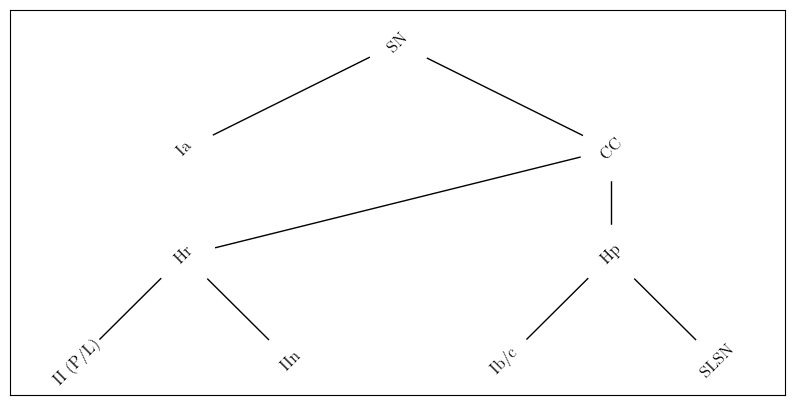

In [74]:
# Create a graph
G=nx.DiGraph()

G.add_edge('SN', 'Ia')
G.add_edge('SN', 'CC')

G.add_edge('CC', 'Hr')
G.add_edge('Hr', 'II (P/L)')
G.add_edge('Hr', 'IIn')

G.add_edge('CC', 'Hp')
G.add_edge('Hp', 'Ib/c')
G.add_edge('Hp', 'SLSN')

pos = hxetda.hierarchy_pos(G, 'SN')
vertices = np.array(list(label_dict.values()) + ['CC', 'Hr', 'Hp'], dtype=str)
vertices = np.insert(vertices, 0, 'SN')
print(vertices)

fig = plt.figure(1, figsize=(10, 5))

nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)
for _, t in text.items():
    t.set_rotation(45) 

plt.show()

In [75]:
# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][z_mask & good_class_mask].to_numpy()
label_dict = {0.0: 'Ia', 1.0: 'Ib/c', 2.0: 'SLSN', 3.0: 'IIn', 4.0: 'II (P/L)'}
pstar_y_labs = np.array([label_dict[y] for y in pstar_y])

# Regularize the predictors
scaler = StandardScaler()
pstar_X = scaler.fit_transform(pstar_X)

# Get paths
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'SN')

# Some pre-processing for the class weights
class_weight_dict = hxetda.calc_class_weights(pstar_y_labs, vertices, paths)
print(class_weight_dict)

{'II (P/L)': array([1.15509677]), 'IIn': array([7.0488189]), 'Ia': array([0.27900888]), 'Ib/c': array([2.74601227]), 'SLSN': array([22.66329114])}


In [76]:
# Label dictionary
labels_y = np.array([label_dict[c] for c in pstar_y])

# Get weights
class_weight_dict = hxetda.calc_class_weights(labels_y, vertices, paths)

# Set up for train test split...
labels_new = [y_dict[x] for x in labels_y]
weights = [class_weight_dict[x] for x in labels_y]
if not isinstance(pstar_X, torch.Tensor):
    pstar_X = torch.from_numpy(pstar_X)
# if not isinstance(labels_new, torch.Tensor):
#     labels_new = torch.from_numpy(labels_new)
X_train, X_test, y_train, y_test, labels_train, labels_test, weights_train, weights_test = train_test_split(pstar_X, labels_new, pstar_y_labs, weights, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

weights_train = torch.tensor(weights_train, dtype=torch.float64)
weights_test = torch.tensor(weights_test, dtype=torch.float64)

print(np.shape(X_train))

torch.Size([7161, 4])


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/2291217901.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/2291217901.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float64)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/2291217901.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/c_/qfmhj66j0t

7161


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/1139798743.py:29: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/1139798743.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)


1 -0.29074922676838955 -0.3568652645418454
101 -0.2984656160438769 -0.3902293878094958
201 -0.30146537967482306 -0.3935041011607778
301 -0.3045857700023613 -0.39481378735264516
401 -0.3055659174583365 -0.39553961501627033
501 -0.30511777858694233 -0.395953444826447
601 -0.3048522978686722 -0.3961594192848361
701 -0.3049290103101663 -0.39626453748189366
801 -0.30519587421722694 -0.3963038072255057
901 -0.305633348473927 -0.3963400477627437


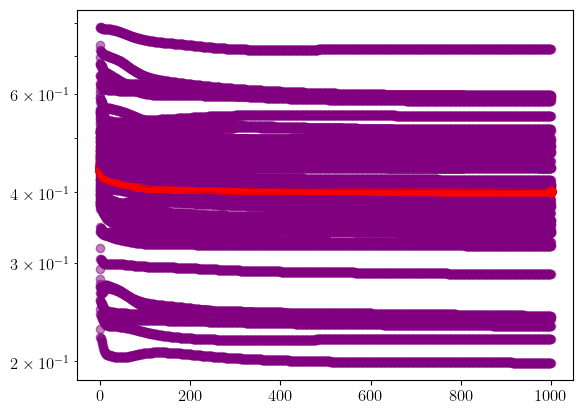

In [79]:
alphas = [2.0]
for alpha, col in zip(alphas, ('purple', 'blue', 'green')):
	model = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(vertices))
	optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
	model.train()
	epoch = 1000
	n_batches = 128
	loss=torch.tensor(0)
	print(len(X_train))
	for epoch in range(epoch):
		if epoch%100==1:
			print(epoch, np.log10(loss.detach().numpy()), np.log10(loss2.detach().numpy()))
		for i in range(int(len(X_train)/n_batches)+1):

			# Local batches and labels
			local_X, local_y, local_weights = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,], weights_train[i*n_batches:(i+1)*n_batches,]
			local_X = local_X.to(torch.float64)  # Ensure local_X is float32
			optimizer.zero_grad()

			# Forward pass
			y_pred = model(local_X)

			# Compute Loss
			loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), local_weights, mask_list, pathlengths)

			# Backward pass
			loss.backward()
			optimizer.step()
			plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)
			ypred2 = model(X_test)
			loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), weights_test, mask_list, pathlengths)
			plt.plot(epoch,loss2.detach().numpy(),'ro', lw=0.1, alpha=0.5)

	#scheduler.step()
	plt.yscale('log')
	plt.show()

In [89]:
model.eval()
y_pred = model(X_test)

In [90]:
leaves = np.array(list(label_dict.values()), dtype=str)
probs_list = np.zeros((len(y_pred), len(leaves)))
for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred, leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]
fiveleaf_labels_test = np.copy(labels_test)

for i,s in enumerate(fiveleaf_labels_test):
    is_Ibc = hxetda.is_parent(s, 'SN Ib/c', vertices, paths)
    if is_Ibc:
        fiveleaf_labels_test[i] = 'SN Ib/c'

gind = np.where(np.in1d(fiveleaf_labels_test,leaves))[0]
cm_hier = confusion_matrix(fiveleaf_labels_test[gind], my_predicted_types[gind], labels=leaves)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/3131542241.py:11: RuntimeWarning: invalid value encountered in divide
  cm1_norm = cm1 / cm1_col_norms
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/3131542241.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_48461/3131542241.py:42: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


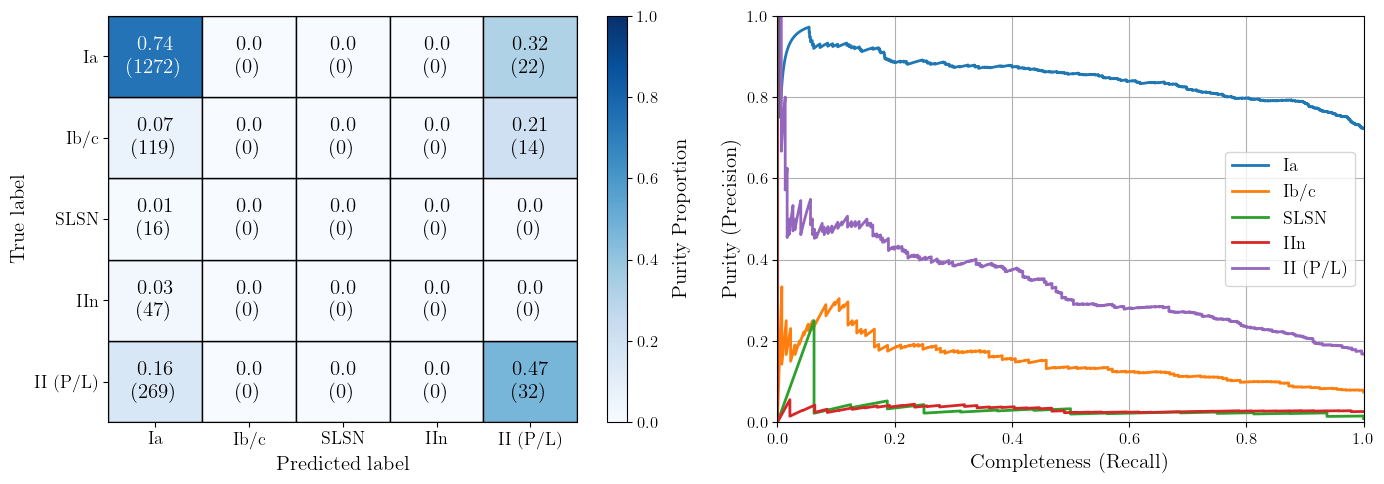

In [91]:
from itertools import cycle

# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(cm_hier)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (labels_test == class_labels[i])
    proba_binary = probs_list[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.legend(fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()

# Testing the pipeline class out

In [21]:
import importlib
import SPLASH
import SPLASH.pipeline

importlib.reload(SPLASH.pipeline)

from SPLASH.pipeline import Splash_Pipeline
test_pipe = Splash_Pipeline()

/Users/adamboesky/opt/anaconda3/envs/ay98_updated/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNNImputer from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
test_classes = test_pipe.predict_classes(pstar_photo_copy,
                          angular_sep=get_angular_separation(panstarr_df['raStack_3pi'], panstarr_df['decStack_3pi'], panstarr_df['SN_ra'], panstarr_df['SN_dec'], unit1='deg', unit2='deg'),
                          X_grizy_err=pstar_photo_err_copy,
                          n_resamples=50)

In [23]:
pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
get_angular_separation(panstarr_df['raStack_3pi'], panstarr_df['decStack_3pi'], panstarr_df['SN_ra'], panstarr_df['SN_dec'], unit1='deg', unit2='deg'), pstar_X[:, 0]

(array([ 1.03698097, 16.03135623, 20.41978979, ..., 11.49909189,
         8.51096664, 39.24083309]),
 array([0.01577079, 1.20497026, 0.92318261, ..., 1.06066354, 0.92997889,
        1.59373822]))

In [24]:
test_pipe.predict_host_properties(pstar_photo_copy, pstar_photo_err_copy, n_resamples=50, return_normalized=False), pstar_props_norm, pstar_props

((array([[ 8.84095619e+00, -1.48977824e+00,  8.93104837e-02],
         [ 1.07117093e+01, -1.41974281e-01,  1.04020043e-01],
         [ 1.16210326e+01, -2.87639897e-01, -8.26360869e-03],
         ...,
         [ 1.09577866e+01, -2.57293997e-01,  4.63576876e-02],
         [ 1.10437314e+01, -5.21178697e-01,  1.08293401e-01],
         [ 1.15033896e+01, -1.84712632e-01,  4.36194895e-04]]),
  array([[3.69704200e-01, 3.97812379e-01, 3.79572002e-02],
         [7.14365706e-03, 1.07271304e-02, 6.23610449e-04],
         [1.08676588e-04, 5.07556741e-04, 2.34779466e-05],
         ...,
         [1.73959980e-03, 1.09506349e-03, 2.08007714e-04],
         [1.77630309e-03, 7.42363010e-03, 2.75658191e-04],
         [1.40245376e-04, 3.10817334e-04, 1.60673625e-05]])),
 array([[-0.19633267, -1.2522008 , -1.91637677],
        [ 1.69480886,  0.30524499, -1.79940418],
        [ 2.53484041,  0.16593874, -2.21494228],
        ...,
        [ 1.92395721,  0.19453935, -2.01279865],
        [ 2.00238762, -0.0571584

In [25]:
test_pipe.predict_host_properties(pstar_photo_copy, pstar_photo_err_copy, n_resamples=50), pstar_X[:, 1:]

((array([[ 8.75363495e+00, -1.54941806e+00,  9.89033191e-02],
         [ 1.07114736e+01, -1.39491382e-01,  1.04017065e-01],
         [ 1.16210548e+01, -2.87600571e-01, -8.26347969e-03],
         ...,
         [ 1.09583162e+01, -2.57444307e-01,  4.63635611e-02],
         [ 1.10426554e+01, -5.22239907e-01,  1.08186126e-01],
         [ 1.15034598e+01, -1.84637403e-01,  4.37783916e-04]]),
  array([[3.47066648e-01, 4.02049821e-01, 3.60659398e-02],
         [6.02571581e-03, 1.16404671e-02, 5.70184611e-04],
         [1.29161550e-04, 5.56482038e-04, 2.63963181e-05],
         ...,
         [1.47547972e-03, 1.07273215e-03, 2.10154335e-04],
         [1.98152997e-03, 7.76396759e-03, 3.00718994e-04],
         [1.43011217e-04, 3.04741111e-04, 1.53080866e-05]])),
 array([[ 8.65787096e+00, -1.76296234e+00,  7.23657942e-02],
        [ 1.07096576e+01, -1.42841780e-01,  1.03956370e-01],
        [ 1.06405964e+01,  4.79319233e-01,  1.20428585e-01],
        ...,
        [ 1.09582712e+01, -2.58002434e-01,  4

In [26]:
# Checking that masking works
test_classes[within_training_mask & z_mask & good_class_mask].shape, pstar_y.shape

((8829,), (8829,))

In [27]:
confusion_matrix(pstar_y, test_classes[within_training_mask & z_mask & good_class_mask]), np.all(pstar_y==final_classes), np.sum(final_classes==test_classes[within_training_mask & z_mask & good_class_mask])/len(final_classes)

(array([[6352,    0,    0,    0,    0],
        [   0,  631,    0,    0,    0],
        [   0,    0,   79,    0,    0],
        [   0,    0,    0,  250,    0],
        [   0,    0,    0,    0, 1517]]),
 True,
 1.0)

In [48]:
with open('mask.pkl', 'wb') as f:
    pickle.dump(within_training_mask & z_mask & good_class_mask, f)

# with open('/Users/adamboesky/Research/ay98/Weird_Galaxies/mask.pkl', 'rb') as f:
#     mask = pickle.load(f)

with open('final_classes.pkl', 'wb') as f:
    pickle.dump(final_classes, f)

# with open('/Users/adamboesky/Research/ay98/Weird_Galaxies/final_classes.pkl', 'rb') as f:
#     final_classes = pickle.load(f)

In [28]:
confusion_matrix(pstar_y, test_classes[within_training_mask & z_mask & good_class_mask]), np.all(pstar_y==final_classes)  # confirm that the pipeline looks alright

(array([[6352,    0,    0,    0,    0],
        [   0,  631,    0,    0,    0],
        [   0,    0,   79,    0,    0],
        [   0,    0,    0,  250,    0],
        [   0,    0,    0,    0, 1517]]),
 True)

In [29]:
with open('final_classes.pkl', 'rb') as f:
    final_classes = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'final_classes.pkl'